# Findings Notebook - Feature Engineering and Fraud Analysis

This notebook contains data analysis on the features (merchant and consumer fraud) and also performs feature engineering on the data.

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
import os
import re
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager
import sklearn

In [4]:
spark = (
    SparkSession.builder.appName('Insights and Findings 1')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '7g')
    .config('spark.executor.memory', '3g')
    .getOrCreate()
)

24/10/18 21:35:54 WARN Utils: Your hostname, Alans-MacBook-Air-4.local resolves to a loopback address: 127.0.0.1; using 192.168.0.52 instead (on interface en0)
24/10/18 21:35:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/18 21:35:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/18 21:35:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/18 21:35:56 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [8]:
#This file contains all the data with the imputed fraud values and preprocessed retail sales data.
sdf = spark.read.parquet(".././data/curated/transactions_preprocessed.parquet")

In [4]:
sdf.show()

24/10/18 17:03:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+----+--------+--------------+------------+-------+-----------+------------------+--------------------+-------------+-----------------+-----+------+------------------+--------------------+--------------------+----+---------+--------------------------+----------+--------------+----------------+----------------+------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+--------------------+--------------------+-------------------+-----------+------------+-----------+----------+--------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|consumer_name|          address|state|gender| fraud_probability|       merchant_name|                tags|type|take_rate|merchant_fraud_probability|AREASQKM21|    SHAPE_Leng|      SHAPE_Area|             lon|               lat|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekl

Calculate the Range of Fraud Probabilites along with outliers
merchant_stats.pandas_api().plot.scatter

In [5]:
sdf.printSchema()

root
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_abn: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- fraud_probability: double (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- type: string (nullable = true)
 |-- take_rate: double (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)
 |-- AREASQKM21: double (nullable = true)
 |-- SHAPE_Leng: double (nullable = true)
 |-- SHAPE_Area: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- 

#### Analysis of Average Merchant Fraud

In [6]:
average_fraud = sdf.groupBy('merchant_abn').agg(F.avg('merchant_fraud_probability').alias('average_fraud'))
average_fraud

In [ ]:
df2 = average_fraud.pandas_api()
pdf = average_fraud.toPandas()

<Figure size 800x600 with 0 Axes>

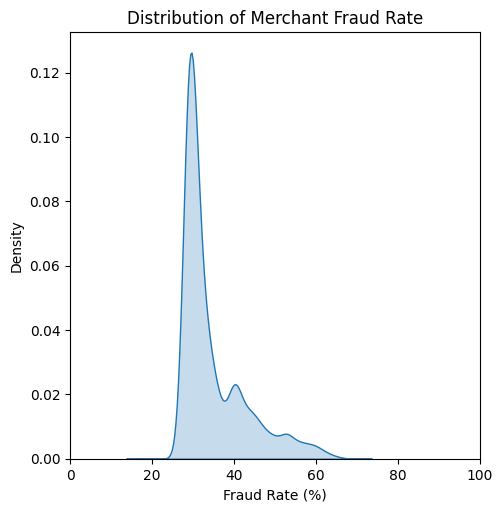

In [11]:
plt.figure(figsize=(8, 6), frameon=False)
sns.displot(data = pdf, x='average_fraud', bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)
ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Merchant Fraud Rate")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Density")
plt.xlim((0, 100))
plt.xlim(0)

plt.show()

Filter Merchants with a High Fraud Probability

In [13]:
high_merchant_fraud = average_fraud.filter(F.col('average_fraud') > 50)
high_merchant_fraud.select('merchant_abn').distinct().count()

There are 266 merchants with a fraud probabiltity that is considered as an outlier

Feature Engineering based on Merchant's to get sales, revenue, fraud, number of customers, days with sales etc.,

In [9]:
sdf2 = sdf.groupBy('merchant_abn', 'tags', 'take_rate', 'type').agg(F.sum('dollar_value').alias('Total Revenue'), F.count('*').alias('Total Sales'), F.avg('merchant_fraud_probability').alias('Merchant Fraud'), F.avg('fraud_probability').alias('Consumer Fraud'), F.avg('Median_tot_fam_inc_weekly').alias('Median Family Income'), F.avg('seasonal_sales'), F.avg('original_sales'), F.avg('Average_household_size').alias('Average Household Size'), F.countDistinct('consumer_id').alias('Unique Customers'), F.avg('expected_revenue').alias('Average Expected Revenue'), F.countDistinct('order_datetime').alias('Days with Sales'))

In [16]:
sdf2.show()

This file contains the engineered features. 

In [10]:
sdf2.write.mode('overwrite').parquet('.././data/curated/filtered')

Find average consumer fraud for each merchant 

In [18]:
df = spark.read.parquet('.././data/curated/filtered')

In [19]:
df.show()

+------------+--------------------+---------+----+------------------+-----------+------------------+------------------+--------------------+-------------------+-------------------+----------------------+----------------+------------------------+---------------+
|merchant_abn|                tags|take_rate|type|     Total Revenue|Total Sales|    Merchant Fraud|    Consumer Fraud|Median Family Income|avg(seasonal_sales)|avg(original_sales)|Average Household Size|Unique Customers|Average Expected Revenue|Days with Sales|
+------------+--------------------+---------+----+------------------+-----------+------------------+------------------+--------------------+-------------------+-------------------+----------------------+----------------+------------------------+---------------+
| 28687004922|computer programm...|     3.88|   b|1199539.6177607474|      11884|29.145120033052184|14.219447100047875|  1976.8873274991586|  6432.504930999647|  6422.561098956571|    2.4543840457758335|           

In [20]:
df.count()

4026

In [21]:
pdf = df.pandas_api()
pdf['Consumer Fraud'].plot.density(bw_method = 0.3, title = 'Density graph of Consumer Fraud')

Only 3% of merchants have consumer fraud that is considered as an outlier

In [24]:
high_consumer = df.filter(F.col('Consumer Fraud') > 17.46632)

#### Merchant Tags

In [25]:
tags = sdf.groupBy('tags').agg(F.sum('dollar_value').alias('Total Revenue'), F.count('*').alias('Total Sales')).sort('Total Sales')
tags.count()

In [27]:
tags.pandas_api().plot.bar('tags', 'Total Sales')

In [28]:
tags.pandas_api().plot.bar('tags', 'Total Revenue')

In [29]:
tags_types = tags.select(F.col('tags'))
tags_types = tags_types.toPandas()['tags'].tolist()
tags_types